In [1]:
# import what we need for this analysis of historical trading multiples for selected SAAS companies
import pandas as pd
import numpy as np
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.pipeline.data import Fundamentals
from quantopian.research import run_pipeline

# Create our customer ticker list
symbols = Fundamentals.symbol.latest.element_of("""
    TEAM SEND PAYC WDAY NOW HUBS ZEN RNG APPF QLYS CRM PCTY PFPT RP LOGM INST YEXT MIME ADBE MB QTWO
    OKTA NEWR FIVN COUP BOX
""".split())

In [2]:
class TrailingTwelveMonths(CustomFactor):
    window_length=400
    window_safe = True
    mask=symbols
    outputs="""
        factor
        asof_date
        """.split()
    def compute(self, today, assets, out, values, dates):
        out.factor[:] = [
            (v[d + np.timedelta64(52, 'W') > d[-1]])[
                np.unique(
                    d[d + np.timedelta64(52, 'W') > d[-1]],
                    return_index=True
                )[1]
            ].sum()
            for v, d in zip(values.T, dates.T)
        ]
        out.asof_date[:] = dates[-1]
def make_pipeline():
    (
        total_revenue_ttm,
        total_revenue_ttm_asof_date
    ) = TrailingTwelveMonths(
        inputs=[
            Fundamentals.total_revenue,
            Fundamentals.total_revenue_asof_date,
        ]
    )
    enterprise_value = Fundamentals.enterprise_value.latest
    market_cap = Fundamentals.market_cap.latest
    enterprise_value_ttm_rev = Fundamentals.enterprise_value.latest / total_revenue_ttm
    
    return Pipeline(
        columns={
            #'ent_value': enterprise_value,
            #'mkt_value': MarketCap(),
            'ev_ttm_rev': enterprise_value_ttm_rev
            #'total_revenue_ttm': total_revenue_ttm,
            #'total_revenue_ttm_asof_date': total_revenue_ttm_asof_date
        },
        screen=symbols
    )
df = run_pipeline(make_pipeline(), '2018-1-01', '2019-1-24')
#df['total_revenue_ttm_asof_date'] = df['total_revenue_ttm_asof_date'].astype('datetime64[ns]')
df.head()

ev_ttm_rev
2018-01-02 00:00:00+00:00 Equity(114 [ADBE])     11.966616
                          Equity(26401 [CRM])     7.294119
                          Equity(38560 [LOGM])    7.179605
                          Equity(40030 [RP])      6.262215
                          Equity(42825 [PFPT])    8.188433

In [3]:
# unstack the dataframe to create tickers as columns
new_df = df.unstack()
new_df.head(2)

ev_ttm_rev                      \
                          Equity(114 [ADBE]) Equity(26401 [CRM])   
2018-01-02 00:00:00+00:00          11.966616            7.294119   
2018-01-03 00:00:00+00:00          12.141677            7.452802   

                                                                   \
                          Equity(38560 [LOGM]) Equity(40030 [RP])   
2018-01-02 00:00:00+00:00             7.179605           6.262215   
2018-01-03 00:00:00+00:00             7.255172           6.399834   

                                                                    \
                          Equity(42825 [PFPT]) Equity(43127 [NOW])   
2018-01-02 00:00:00+00:00             8.188433           12.414835   
2018-01-03 00:00:00+00:00             8.500690           12.545408   

                                                                     \
                          Equity(43454 [QLYS]) Equity(43510 [WDAY])   
2018-01-02 00:00:00+00:00             8.848112             9.837853   
2018-01-03 00:00:00+00:00             9.149557            10.012579   

                                                                    \
                          Equity(45521 [RNG]) Equity(46569 [PCTY])   
2018-01-02 00:00:00+00:00            7.672582             7.517804   
2018-01-03 00:00:00+00:00            7.572878             7.612387   

                                  ...                               \
                                  ...          Equity(48486 [BOX])   
2018-01-02 00:00:00+00:00         ...                     5.814029   
2018-01-03 00:00:00+00:00         ...                     5.919104   

                                                                   \
                          Equity(49156 [MB]) Equity(49193 [APPF])   
2018-01-02 00:00:00+00:00           7.081477            10.197639   
2018-01-03 00:00:00+00:00           7.176996            10.121590   

                                                                     \
                          Equity(49594 [INST]) Equity(49606 [MIME])   
2018-01-02 00:00:00+00:00             6.384513             7.004518   
2018-01-03 00:00:00+00:00             6.436178             6.890895   

                                                                     \
                          Equity(49655 [TEAM]) Equity(50350 [COUP])   
2018-01-02 00:00:00+00:00            14.566147             8.765207   
2018-01-03 00:00:00+00:00            15.089600             9.025883   

                                                                     \
                          Equity(50758 [OKTA]) Equity(50781 [YEXT])   
2018-01-02 00:00:00+00:00            10.329181             6.233919   
2018-01-03 00:00:00+00:00            10.704129             6.129888   

                                                
                          Equity(51455 [SEND])  
2018-01-02 00:00:00+00:00            18.622845  
2018-01-03 00:00:00+00:00            19.273771  

[2 rows x 26 columns]

In [4]:
# eliminate multi-index columns
new_df.columns = new_df.columns.droplevel()
new_df.head(2)

,Equity(114 [ADBE]),Equity(26401 [CRM]),Equity(38560 [LOGM]),Equity(40030 [RP]),Equity(42825 [PFPT]),Equity(43127 [NOW]),Equity(43454 [QLYS]),Equity(43510 [WDAY]),Equity(45521 [RNG]),Equity(46569 [PCTY]),...,Equity(48486 [BOX]),Equity(49156 [MB]),Equity(49193 [APPF]),Equity(49594 [INST]),Equity(49606 [MIME]),Equity(49655 [TEAM]),Equity(50350 [COUP]),Equity(50758 [OKTA]),Equity(50781 [YEXT]),Equity(51455 [SEND])
2018-01-02 00:00:00+00:00,11.966616,7.294119,7.179605,6.262215,8.188433,12.414835,8.848112,9.837853,7.672582,7.517804,...,5.814029,7.081477,10.197639,6.384513,7.004518,14.566147,8.765207,10.329181,6.233919,18.622845
2018-01-03 00:00:00+00:00,12.141677,7.452802,7.255172,6.399834,8.500690,12.545408,9.149557,10.012579,7.572878,7.612387,...,5.919104,7.176996,10.121590,6.436178,6.890895,15.089600,9.025883,10.704129,6.129888,19.273771


In [5]:
# check to see if there are any NAN values
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 267 entries, 2018-01-02 to 2019-01-24
Data columns (total 26 columns):
Equity(114 [ADBE])      267 non-null float64
Equity(26401 [CRM])     267 non-null float64
Equity(38560 [LOGM])    267 non-null float64
Equity(40030 [RP])      267 non-null float64
Equity(42825 [PFPT])    267 non-null float64
Equity(43127 [NOW])     267 non-null float64
Equity(43454 [QLYS])    267 non-null float64
Equity(43510 [WDAY])    267 non-null float64
Equity(45521 [RNG])     267 non-null float64
Equity(46569 [PCTY])    267 non-null float64
Equity(46578 [QTWO])    267 non-null float64
Equity(46695 [FIVN])    267 non-null float64
Equity(46744 [PAYC])    267 non-null float64
Equity(46918 [ZEN])     267 non-null float64
Equity(47872 [HUBS])    267 non-null float64
Equity(48253 [NEWR])    267 non-null float64
Equity(48486 [BOX])     267 non-null float64
Equity(49156 [MB])      267 non-null float64
Equity(49193 [APPF])    267 non-null float64
Equity(49594 [INST]) 

In [6]:
# change the names of the columns to look nicer for bar chart later
import re
col_tickers = []
for values in new_df.columns.values.tolist():
    col_tickers.append(re.search(r"\[(\w+)\]", str(values)).group(1))
new_df.columns = col_tickers
new_df.head(2)

,ADBE,CRM,LOGM,RP,PFPT,NOW,QLYS,WDAY,RNG,PCTY,...,BOX,MB,APPF,INST,MIME,TEAM,COUP,OKTA,YEXT,SEND
2018-01-02 00:00:00+00:00,11.966616,7.294119,7.179605,6.262215,8.188433,12.414835,8.848112,9.837853,7.672582,7.517804,...,5.814029,7.081477,10.197639,6.384513,7.004518,14.566147,8.765207,10.329181,6.233919,18.622845
2018-01-03 00:00:00+00:00,12.141677,7.452802,7.255172,6.399834,8.500690,12.545408,9.149557,10.012579,7.572878,7.612387,...,5.919104,7.176996,10.121590,6.436178,6.890895,15.089600,9.025883,10.704129,6.129888,19.273771


In [7]:
# calculate the mean of all multiples to create the chart
mean_df = new_df.mean(axis=1)

In [8]:
# calc the average for the period
z_mean = mean_df.mean()
round(z_mean,1)

10.8

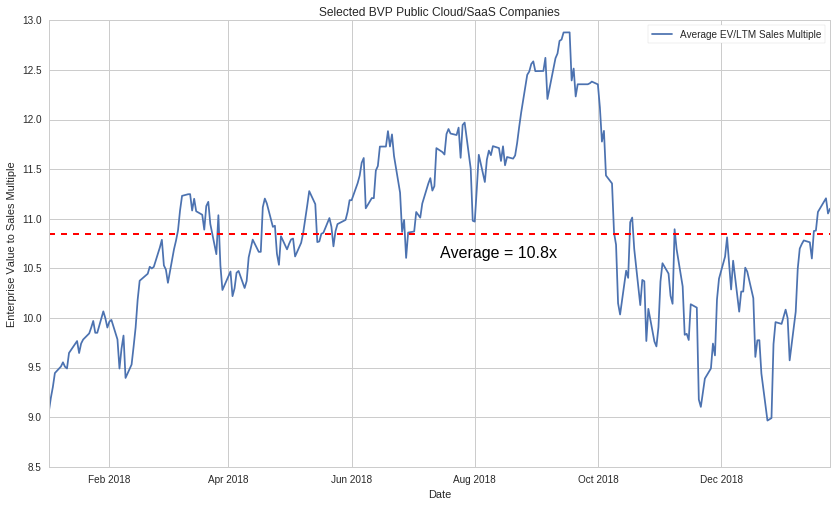

In [19]:
# make the line chart of multiple
import matplotlib.pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots()
x = mean_df.index.values
y = mean_df.values
ax.plot(x,y)

plt.legend(['Average EV/LTM Sales Multiple'],loc='best')
plt.axhline(z_mean, color='r', linestyle='dashed', linewidth=2)
plt.ylabel("Enterprise Value to Sales Multiple")
plt.xlabel("Date")
plt.text(.65, 0.48, 'Average = 10.8x',
        horizontalalignment='right',
        verticalalignment='center',
        fontsize=16, color='black',
        transform=ax.transAxes)
plt.grid(b=True, which=u'major', axis=u'both')
plt.title("Selected BVP Public Cloud/SaaS Companies")
plt.show()

In [20]:
# look at how multiples have changed from beg date to end date
# slice new_df with Saas company mulitples on first date, last date
results_df = new_df.iloc[[0,-1],:]
# sort results by Jan 23
result_sorted = results_df.T.sort_values(by='2019-01-24',ascending= False)
result_sorted

,2018-01-02 00:00:00+00:00,2019-01-24 00:00:00+00:00
OKTA,10.329181,22.965134
TEAM,14.566147,20.792172
COUP,8.765207,17.763635
SEND,18.622845,15.672389
PAYC,11.425151,15.057702
WDAY,9.837853,14.155241
ADBE,11.966616,14.064069
NOW,12.414835,13.094260
ZEN,8.108488,12.564684
NEWR,9.645174,12.148729


In [21]:
#sort tickers for bar chart
sorted_tickers = []
for values in result_sorted.index.values.tolist():
    sorted_tickers.append(values)
sorted_tickers[:5]

['OKTA', 'TEAM', 'COUP', 'SEND', 'PAYC']

In [22]:
# get data for bar chart
bar_df = result_sorted.loc[:,'2019-01-24']

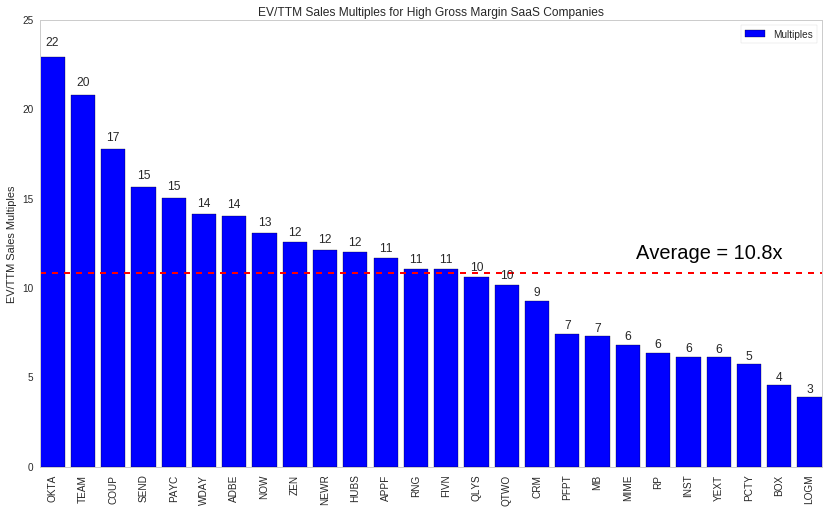

In [23]:
# create the bar chart
N = len(sorted_tickers)
mult = bar_df.values  #.tolist()
ind = np.arange(N)
fig, ax = plt.subplots()
mults = ax.bar(ind,mult,color='b',align="center")  
ax.set_ylabel('EV/TTM Sales Multiples')
ax.set_title("EV/TTM Sales Multiples for High Gross Margin SaaS Companies")

width = 0.45
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(sorted_tickers)

#ax = result_sorted.plot(kind='bar',x=result_sorted.index,title="EV-TTM Sales Multiples", use_index=True)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%d' % int(height), ha='center', va='bottom')
autolabel(mults)
ax.legend(['Multiples'],loc='best')
ax.grid(False)
plt.xticks(ind, (sorted_tickers),rotation='vertical')
plt.axhline(z_mean, color='r', linestyle='dashed', linewidth=2)
#plt.axis('tight') #scaled square
plt.autoscale(enable=True, axis='both', tight=None)
ax.text(0.95, 0.48, 'Average = 10.8x',
        horizontalalignment='right',
        verticalalignment='center',
        fontsize=20, color='black',
        transform=ax.transAxes)
#plt.margins(0.1,0)

fig = plt.figure(figsize=(8,6))
plt.show()

# Create New Pipeline for spread chart

In [24]:
def make_pipeline():
    (
        total_revenue_ttm,
        total_revenue_ttm_asof_date
    ) = TrailingTwelveMonths(
        inputs=[
            Fundamentals.total_revenue,
            Fundamentals.total_revenue_asof_date,
        ]
    )
    enterprise_value = Fundamentals.enterprise_value.latest
    market_cap = Fundamentals.market_cap.latest
    enterprise_value_ttm_rev = Fundamentals.enterprise_value.latest / total_revenue_ttm
    combined_rank = enterprise_value_ttm_rev.rank(mask=symbols)
    #set filters
    sec_high = combined_rank.percentile_between(80,100)
    sec_low = combined_rank.percentile_between(0,20)
    
    sec_to_trade = (sec_high | sec_low)
    
    return Pipeline(
        columns={
            'ev_ttm_rev': enterprise_value_ttm_rev,
            'High Value': sec_high,
            'Low Value': sec_low
        },
        screen=sec_to_trade
    )
df = run_pipeline(make_pipeline(), '2018-2-01', '2019-1-24')
df.head()

High Value Low Value  \
2018-02-01 00:00:00+00:00 Equity(114 [ADBE])         True     False   
                          Equity(40030 [RP])        False      True   
                          Equity(43127 [NOW])        True     False   
                          Equity(46695 [FIVN])      False      True   
                          Equity(46744 [PAYC])       True     False   

                                                ev_ttm_rev  
2018-02-01 00:00:00+00:00 Equity(114 [ADBE])     12.909582  
                          Equity(40030 [RP])      6.976519  
                          Equity(43127 [NOW])    14.215578  
                          Equity(46695 [FIVN])    7.565621  
                          Equity(46744 [PAYC])   13.254838

In [25]:
# Create High Value dataframe
df_high = df[df['High Value']== True].drop(['High Value','Low Value'],axis=1).unstack()
#eliminate multi-index columns
df_high.columns = df_high.columns.droplevel()
df_high_m = df_high.mean(axis=1)

In [26]:
# perform a few checks
print(df_high_m.iloc[-1] == df_high.iloc[-1,:].mean())
print(df_high_m.iloc[0] == df_high.iloc[0,:].mean())

True
True


In [27]:
# check the average for the most recent date
df_high.iloc[-1,:].mean()

17.73437883542656

In [28]:
# check the average for the start date
df_high.iloc[0,:].mean()

14.307796177982217

In [29]:
# Create Low Value dataframe
df_low = df[df['Low Value']== True].drop(['High Value','Low Value'],axis=1).unstack()
#eliminate multi-index columns
df_low.columns = df_low.columns.droplevel()
df_low_m = df_low.mean(axis=1)

In [30]:
# perform a few checks and look at mean values
print(df_low_m.iloc[-1] == df_low.iloc[-1,:].mean())
print(df_low_m.iloc[0] == df_low.iloc[0,:].mean())

True
True


In [31]:
# avg for the most recent date
df_low.iloc[-1,:].mean()

5.484420016000128

In [32]:
# avg for start date
df_low.iloc[0,:].mean()

6.904087230648571

In [33]:
# Concatenate dataframes to create spread 
spread_df = pd.concat([df_high_m,df_low_m],axis=1)
spread_df.columns = ['Top', 'Bottom']
spread_comb_df = spread_df['Top'] - spread_df['Bottom']

In [34]:
# what is the average spread of time period
spr_mean = spread_comb_df.mean()
round(spr_mean,1)

9.7

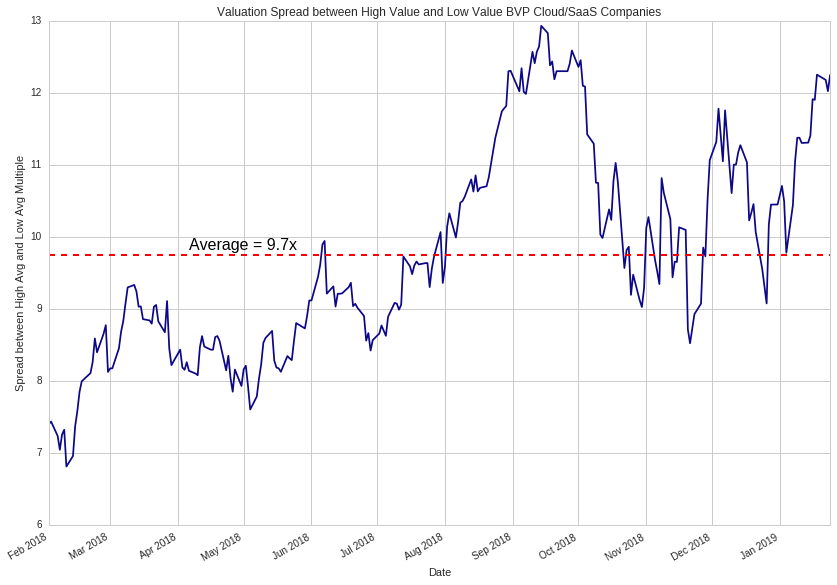

In [35]:
#create line chart
spread_comb_df.plot(colormap='plasma',figsize=(14,10))
plt.ylabel("Spread between High Avg and Low Avg Multiple")
plt.xlabel("Date")
plt.axhline(spr_mean, color='r', linestyle='dashed', linewidth=2)
plt.grid(b=True, which=u'major', axis=u'both')
plt.text(.15, 0.6, 'Average = 9.7x',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16, color='black',
        transform=ax.transAxes)
plt.title("Valuation Spread between High Value and Low Value BVP Cloud/SaaS Companies")
plt.show()